# Robust Real‑Time Alertness Score (0‑100)
Adds missing‑value handling so NaNs never choke the classifier.

In [1]:

import os, pickle, warnings
from pathlib import Path
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from scipy.signal import butter, filtfilt, welch
import mne

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
warnings.filterwarnings('ignore')
sns.set(style="whitegrid")


In [2]:

DATA_ROOT = Path('sample_data')
FS = 125
EPOCH_SEC = 30
MIN_GOOD_RATIO = 0.6
TRAIN_POS, TRAIN_NEG = 'Wake','Deep'


In [3]:

def bandpass(x, fs=FS, low=0.5, high=45, order=4):
    b,a = butter(order, [low/(0.5*fs), high/(0.5*fs)], btype='band')
    return filtfilt(b,a,x)

def epoch_features(epoch, fs=FS):
    bands={'delta':(0.5,4),'theta':(4,8),'alpha':(8,12),'beta':(12,30),'gamma':(30,45)}
    fdict={}
    for ch in range(epoch.shape[0]):
        sig=epoch[ch]
        fdict[f'ch{ch}_mean']=sig.mean()
        fdict[f'ch{ch}_std']=sig.std()
        f,P=welch(sig, fs=fs, nperseg=min(len(sig),4*fs))
        total=np.trapz(P,f)
        for band,(lo,hi) in bands.items():
            mask=(f>=lo)&(f<hi)
            power=np.trapz(P[mask],f[mask])
            fdict[f'ch{ch}_{band}_rel']= power/total if total else 0
    fdict['theta_alpha_ratio']=(
        fdict['ch0_theta_rel']/fdict['ch0_alpha_rel']
        if fdict['ch0_alpha_rel']>0 else 0)
    return fdict


In [4]:

def build_epochs(sd:Path):
    edf=next(sd.glob('*.edf'))
    stage_csv=next(sd.glob('*[0-9].csv'))
    sqc_csv=next(sd.glob('*SQC.csv'))
    raw=mne.io.read_raw_edf(edf, preload=True, verbose=False)
    data=bandpass(raw.get_data()[:4], FS)
    df_stage=pd.read_csv(stage_csv); df_sqc=pd.read_csv(sqc_csv)
    start_ts=df_stage['Timestamp'].min()
    rows=[]
    for _,row in df_stage.iterrows():
        ts=row['Timestamp']; lbl=row['Sleep stage']
        st=int((ts-start_ts)*FS); en=st+EPOCH_SEC*FS
        if en>data.shape[1]: break
        mask=(df_sqc['Timestamp']>=ts)&(df_sqc['Timestamp']<ts+EPOCH_SEC)
        good_ratio=(df_sqc.loc[mask,'Signal quality']=='Good').mean()
        if good_ratio<MIN_GOOD_RATIO: continue
        feats=epoch_features(data[:,st:en])
        feats.update({'good_ratio':good_ratio,'stage':lbl,'record':sd.name})
        rows.append(feats)
    return pd.DataFrame(rows)


In [5]:

sample_dirs=[p for p in DATA_ROOT.iterdir() if p.is_dir()]
if not sample_dirs:
    raise FileNotFoundError("sample_data folder not found or empty.")
all_epochs=pd.concat([build_epochs(p) for p in sample_dirs], ignore_index=True)
print("Epochs:", all_epochs.shape)


Epochs: (16088, 32)


In [6]:

train=all_epochs[all_epochs['stage'].isin([TRAIN_POS,TRAIN_NEG])].copy()
train['y']=(train['stage']==TRAIN_POS).astype(int)
X=train.drop(columns=['stage','record','y'])
y=train['y']; groups=train['record']
gkf=GroupKFold(n_splits=5)
tr_idx, te_idx = next(gkf.split(X,y,groups))
X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
y_tr, y_te = y.iloc[tr_idx], y.iloc[te_idx]


In [7]:

pipe = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler()),
    ('clf', LogisticRegression(max_iter=1000))
])
pipe.fit(X_tr, y_tr)
print("AUC train:", roc_auc_score(y_tr, pipe.predict_proba(X_tr)[:,1]))
print("AUC test :", roc_auc_score(y_te, pipe.predict_proba(X_te)[:,1]))


AUC train: 0.9215094043998775
AUC test : 0.600736984448952


In [8]:

# Fallback NaN‑tolerant model
hgb_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('clf', HistGradientBoostingClassifier())
])
hgb_pipe.fit(X_tr, y_tr)
auc_hgb = roc_auc_score(y_te, hgb_pipe.predict_proba(X_te)[:,1])
auc_lr  = roc_auc_score(y_te, pipe.predict_proba(X_te)[:,1])
chosen = hgb_pipe if auc_hgb > auc_lr else pipe
print("Chosen:", type(chosen.named_steps.get('clf', chosen.steps[-1][1])).__name__)


Chosen: HistGradientBoostingClassifier


In [9]:

def score(m,X): return (m.predict_proba(X)[:,1]*100).clip(0,100)
all_epochs['score']=score(chosen, all_epochs.drop(columns=['stage','record']))


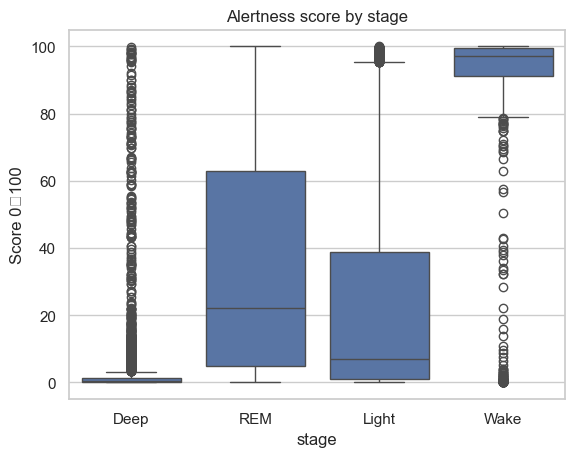

In [10]:

sns.boxplot(x='stage',y='score',data=all_epochs,
            order=['Deep','REM','Light','Wake'])
plt.title('Alertness score by stage')
plt.ylabel('Score 0‑100')
plt.show()


In [11]:

with open('alertness_model.pkl','wb') as f: pickle.dump(chosen,f)
print("Model saved.")


Model saved.


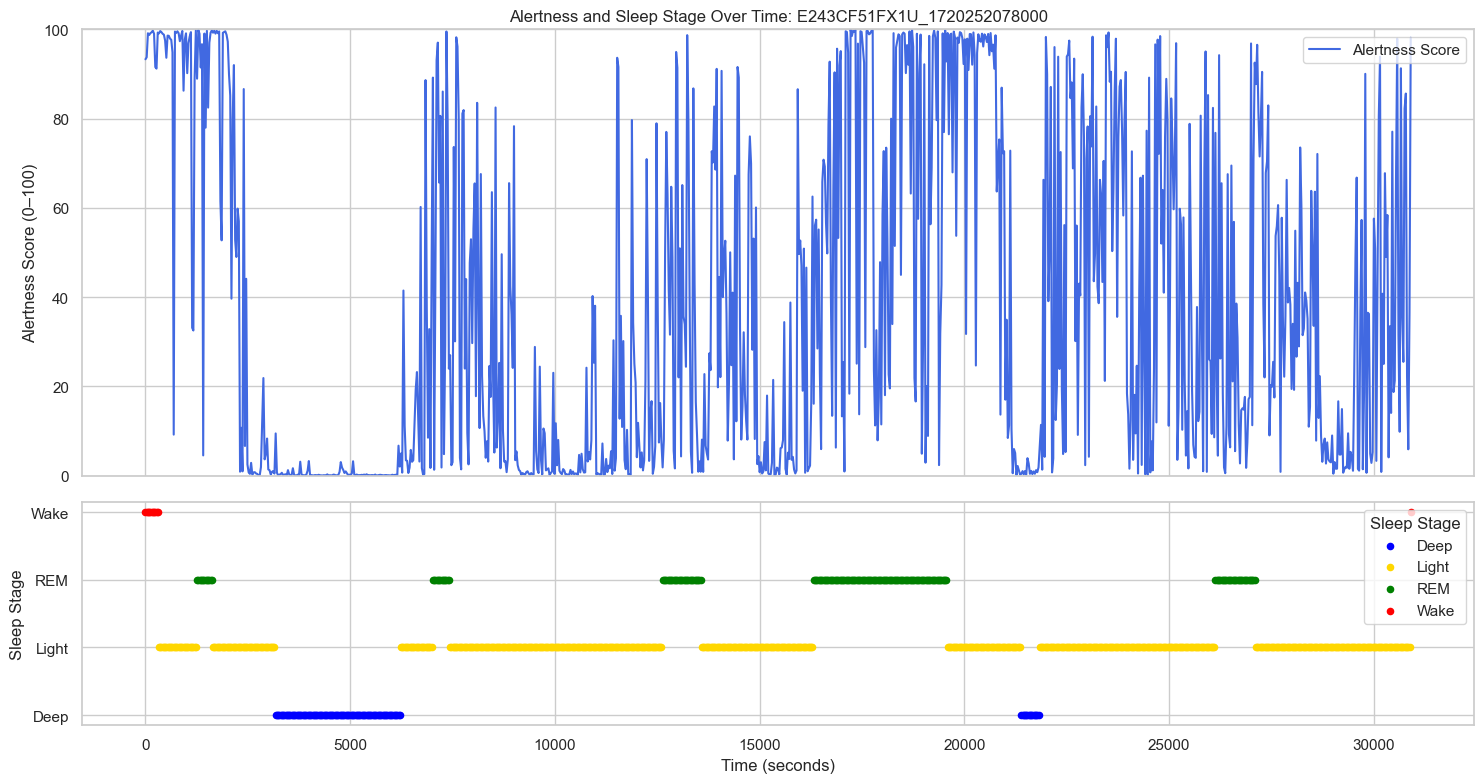

In [13]:
import matplotlib.pyplot as plt

# Select a single record/sample to plot
sample_name = all_epochs['record'].iloc[10]
sample_df = all_epochs[all_epochs['record'] == sample_name].copy()

# Prepare time axis (epoch start times in seconds)
epoch_times = np.arange(len(sample_df)) * EPOCH_SEC

# Plot alertness score
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 8), gridspec_kw={'height_ratios': [2, 1]})

ax1.plot(epoch_times, sample_df['score'], linestyle='-', color='royalblue', label='Alertness Score')
ax1.set_ylabel('Alertness Score (0–100)')
ax1.set_title(f'Alertness and Sleep Stage Over Time: {sample_name}')
ax1.set_ylim(0, 100)
ax1.grid(True)
ax1.legend(loc='upper right')

# Plot sleep stages as colored points
stage_colors = {
    'Deep': 'blue',
    'Light': 'gold',
    'REM': 'green',
    'Wake': 'red'
}
for stage, color in stage_colors.items():
    mask = sample_df['stage'] == stage
    ax2.scatter(epoch_times[mask], [stage]*mask.sum(), color=color, label=stage, s=20)

ax2.set_xlabel('Time (seconds)')
ax2.set_ylabel('Sleep Stage')
ax2.legend(title='Sleep Stage', loc='upper right')
ax2.grid(True)

plt.tight_layout()
plt.show()